In [1]:
import nltk
from nltk.translate.bleu_score import sentence_bleu, corpus_bleu, modified_precision
from nltk.translate.chrf_score import sentence_chrf, corpus_chrf
from nltk.metrics import scores
import scipy.io.wavfile
from IPython.display import Audio
from IPython.display import display
from nltk.stem import *
# from nltk.stem.snowball import SnowballStemmer
from stemming.porter2 import stem
import stemming
from nltk.metrics.scores import recall

from nltk.corpus import stopwords

%matplotlib inline

In [2]:
tableau20 = [(31, 119, 180), (174, 199, 232), (255, 127, 14), (255, 187, 120),    
             (44, 160, 44), (152, 223, 138), (214, 39, 40), (255, 152, 150),    
             (148, 103, 189), (197, 176, 213), (140, 86, 75), (196, 156, 148),    
             (227, 119, 194), (247, 182, 210), (127, 127, 127), (199, 199, 199),    
             (188, 189, 34), (219, 219, 141), (23, 190, 207), (158, 218, 229)]    
# Scale the RGB values to the [0, 1] range, which is the format matplotlib accepts.    
for i in range(len(tableau20)):    
    r, g, b = tableau20[i]    
    tableau20[i] = (r / 255., g / 255., b / 255.)

In [3]:
smooth_fun = nltk.translate.bleu_score.SmoothingFunction()

In [4]:
from nmt_run import *

In [5]:
cfg_path = "./sp2enw/sp_.50"

In [6]:
last_epoch, model, optimizer, m_cfg, t_cfg = check_model(cfg_path)

cnn_out_dim = rnn_in_units =  320


/afs/inf.ed.ac.uk/group/project/lowres/work/miniconda3/envs/chainer3/lib/python3.6/site-packages/chainer/utils/experimental.py:104: FutureWarning: chainer.links.normalization.layer_normalization.py is experimental. The interface can change in the future.
  FutureWarning)


using ADAM optimizer
--------------------------------------------------------------------------------
model found = 
./sp2enw/sp_.50/seq2seq_130.model
finished loading ..
optimizer not found


In [7]:
log_train = np.loadtxt(os.path.join(cfg_path, "train.log"), delimiter=',', skiprows=False).transpose()
log_test = np.genfromtxt(os.path.join(cfg_path, "dev.log"), delimiter=',', usecols = (0,1,2)).transpose()

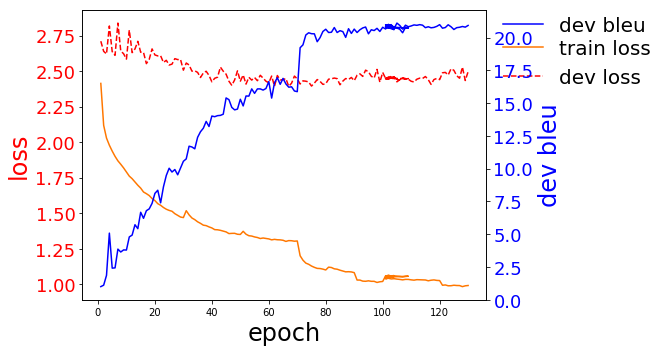

In [8]:
fig, ax1 = plt.subplots()
fig.set_size_inches(8,5)
ax1.plot(log_train[0], log_train[1], color='#ff7700')
ax1.plot(log_test[0], log_test[1], 'r--')
ax1.set_xlabel('epoch', size=24)
ax1.set_ylabel('loss', color='r', size=24)
for tl in ax1.get_yticklabels():
    tl.set_color('r')
    tl.set_fontsize(18)
plt.legend(['train loss', 'dev loss'], bbox_to_anchor=(1.45, 0.96), framealpha=0, fontsize=20)    
ax2 = ax1.twinx()
ax2.plot(log_test[0], log_test[2]*100, 'b-')
ax2.set_xlabel('iteration')
ax2.set_ylabel('dev bleu', color='b', size=24)
# ax1.set_xlim(0, 60)
for tl in ax2.get_yticklabels():
    tl.set_color('b')
    tl.set_fontsize(18) 
plt.legend(['dev bleu'], bbox_to_anchor=(1.44, 1.04), framealpha=0, fontsize=20)
# plt.legend(['dev bleu'], bbox_to_anchor=(1.06, 0.9), framealpha=0, fontsize=20)
plt.grid(False)
plt.tight_layout()

In [9]:
import nltk.translate.bleu_score

In [10]:
def play_utt(utt, m_dict):
    sr, y = scipy.io.wavfile.read(os.path.join(wavs_path, utt.rsplit("-",1)[0]+'.wav'))
    start_t = min(seg['start'] for seg in m_dict[utt]['seg'])
    end_t = max(seg['end'] for seg in m_dict[utt]['seg'])
    print(start_t, end_t)
    start_t_samples, end_t_samples = int(start_t*sr), int(end_t*sr)
    display(Audio(y[start_t_samples:end_t_samples], rate=sr))

In [11]:
def display_words(m_dict, v_dict, preds, utts, dec_key, key, play_audio=False, displayN=-1):
    if displayN == -1:
        displayN = len(utts)
    es_ref = []
    en_ref = []
    for u in utts:
        es_ref.append(" ".join([w.decode() for w in m_dict[u]['es_w']]))
        if type(m_dict[u][dec_key]) == list:
            en_ref.append(" ".join([w.decode() for w in m_dict[u]['en_w']]))
        else:
            en_ref.append(" ".join([w.decode() for w in m_dict[u]['en_w'][0]]))

    en_pred = []
    join_str = ' ' if dec_key.endswith('_w') else ''

    for p in preds:
        t_str = join_str.join([v_dict['i2w'][i].decode() for i in p])
        t_str = t_str[:t_str.find('_EOS')]
        en_pred.append(t_str)

    for u, es, en, p in sorted(list(zip(utts, es_ref, en_ref, en_pred)))[:displayN]:
        # for reference, 1st word is GO_ID, no need to display
        print("Utterance: {0:s}".format(u))
        display_pp = PrettyTable(["cat","sent"], hrules=True)
        display_pp.align = "l"
        display_pp.header = False
        display_pp.add_row(["es ref", textwrap.fill(es,50)])
        display_pp.add_row(["en ref", textwrap.fill(en,50)])
        display_pp.add_row(["en pred", textwrap.fill(p,50)])

        print(display_pp)
        if play_audio:
            play_utt(u, m_dict)
    

### Fisher dev

In [12]:
train_key = m_cfg['train_set']
dev_key = m_cfg['dev_set']
batch_size=t_cfg['batch_size']
enc_key=m_cfg['enc_key']
dec_key=m_cfg['dec_key']
input_path = os.path.join(m_cfg['data_path'], m_cfg['dev_set'])
# -------------------------------------------------------------------------
# get data dictionaries
# -------------------------------------------------------------------------
map_dict, vocab_dict, bucket_dict = get_data_dicts(m_cfg)
batch_size = {'max': 96, 'med': 128, 'min': 256, 'scale': 1}

--------------------------------------------------
loading dict: ../chainer2/speech2text/both_fbank_out/map.dict
loading dict: ../chainer2/speech2text/both_fbank_out/train_vocab.dict
--------------------------------------------------
--------------------------------------------------
loading info_dict from=../chainer2/speech2text/both_fbank_out/info.dict
--------------------------------------------------
creating buckets for: fisher_dev
creating buckets for key: sp


 35%|███▌      | 48717/138708 [00:00<00:00, 487042.73it/s]

creating buckets for: fisher_dev2
creating buckets for key: sp
creating buckets for: fisher_test
creating buckets for key: sp
creating buckets for: fisher_train
creating buckets for key: sp


100%|██████████| 14284/14284 [00:00<00:00, 482382.61it/s]


creating buckets for: callhome_devtest
creating buckets for key: sp
creating buckets for: callhome_evltest
creating buckets for key: sp
creating buckets for: callhome_train
creating buckets for key: sp
--------------------------------------------------
saving info dict in: ../chainer2/speech2text/both_fbank_out/buckets_sp.dict
all done ...
loading dict: ../chainer2/speech2text/both_fbank_out/buckets_sp.dict
--------------------------------------------------
utterances in fisher_dev = 3979
utterances in fisher_dev2 = 3961
utterances in fisher_test = 3641
utterances in fisher_train = 138819
utterances in callhome_devtest = 3966
utterances in callhome_evltest = 1829
utterances in callhome_train = 15080
vocab size for sp = 0
vocab size for en_w = 17378


In [13]:
random.seed("meh")
# random.seed("haha")

In [14]:
# Eval parameters
ref_index = -1
min_len, max_len= 0, m_cfg['max_en_pred']
# min_len, max_len = 0, 5
displayN = 50
m_dict=map_dict[dev_key]
# wavs_path = os.path.join(m_cfg['data_path'], "wavs")
wavs_path = os.path.join("../chainer2/speech2text/both_fbank_out/", "wavs")
v_dict = vocab_dict['en_w']
key = m_cfg['dev_set']

In [15]:
os.chdir("..")
os.chdir("/afs/inf.ed.ac.uk/group/project/lowres/work/speech2text")

### View model

In [16]:
eg_utt = "20051023_232057_325_fsp-A-3"

eg_utt_bucket = -1
for i, bucket in enumerate(bucket_dict[dev_key]["buckets"]):
    if eg_utt in bucket:
        eg_utt_bucket = i
        print("found")
    # end if
# end for
print(eg_utt_bucket)
width_b = bucket_dict[dev_key]["width_b"]

found
3


In [17]:
utt_list = [eg_utt]

In [18]:
batch_data = get_batch(m_dict, 
                       enc_key,
                       dec_key,
                       utt_list,
                       vocab_dict,
                       (eg_utt_bucket+1) * width_b,
                       200,
                       input_path=input_path)

In [19]:
batch_data['y'].shape

(1, 15)

In [90]:
def make_pred(X, y=None):
    # get shape
    batch_size = X.shape[0]
    # encode input
    model.forward_enc(X)
    # ---------------------------------------------------------------------
    # initialize decoder LSTM to final encoder state
    # ---------------------------------------------------------------------
    model.set_decoder_state()
    # ---------------------------------------------------------------------
    # swap axes of the decoder batch
    if y is not None:
        y = F.swapaxes(y, 0, 1)
    # -----------------------------------------------------------------
    # predict
    # -----------------------------------------------------------------
    # make return statements consistent
    return(decode_display(batch_size=batch_size,
                          pred_limit=model.m_cfg['max_en_pred'],
#                           pred_limit=20,
                          y=y))

In [109]:
def decode_display(batch_size, pred_limit, y=None):
    xp = cuda.cupy if model.gpuid >= 0 else np
    # max number of predictions to make
    # if labels are provided, this variable is not used
    stop_limit = pred_limit
    # to track number of predictions made
    npred = 0
    # to store loss
    loss = 0
    # if labels are provided, use them for computing loss
    compute_loss = True if y is not None else False
    # ---------------------------------------------------------------------
    if compute_loss:
        stop_limit = len(y)-1
        # get starting word to initialize decoder
        curr_word = y[0]
    else:
        # intialize starting word to GO_ID symbol
        curr_word = Variable(xp.full((batch_size,), GO_ID, dtype=xp.int32))
    # ---------------------------------------------------------------------
    # flag to track if all sentences in batch have predicted EOS
    # ---------------------------------------------------------------------
    with cupy.cuda.Device(model.gpuid):
        check_if_all_eos = xp.full((batch_size,), False, dtype=xp.bool_)
    # ---------------------------------------------------------------------
    a_units = m_cfg['attn_units']
    ht = Variable(xp.zeros((batch_size, a_units), dtype=xp.float32))
    # ---------------------------------------------------------------------
    while npred < (stop_limit):
        # -----------------------------------------------------------------
        # decode and predict
        pred_out, ht = model.decode(curr_word, ht)
        pred_word = F.argmax(pred_out, axis=1)
        pred_probs = xp.asnumpy(F.softmax(pred_out).data[0])
        top_5_probs = np.argsort(pred_probs)[-5:]
        print("-"*60)
        print("predicting word : {0:d}".format(npred))
        for pi in top_5_probs[::-1]:
            print("{0:10s} = {1:5.3f}".format(v_dict['i2w'][pi].decode(), pred_probs[pi]))
        #print(pred_probs)
        # -----------------------------------------------------------------
        # save prediction at this time step
        # -----------------------------------------------------------------
        if npred == 0:
            pred_sents = pred_word.data
        else:
            pred_sents = xp.vstack((pred_sents, pred_word.data))
        # -----------------------------------------------------------------
        if compute_loss:
            # compute loss
            loss += F.softmax_cross_entropy(pred_out, y[npred+1],
                                               class_weight=model.mask_pad_id)
        # -----------------------------------------------------------------
        curr_word = pred_word
        # check if EOS is predicted for all sentences
        # -----------------------------------------------------------------
        check_if_all_eos[pred_word.data == EOS_ID] = True
        if xp.all(check_if_all_eos):
            break
        # -----------------------------------------------------------------
        # increment number of predictions made
        npred += 1
        # -----------------------------------------------------------------
    return pred_sents.T, loss

In [110]:
with chainer.using_config('train', False):
    cuda.get_device(t_cfg['gpuid']).use()
    preds, _ = make_pred(X=batch_data['X'])
    loss_val = 0.0

------------------------------------------------------------
predicting word : 0
i          = 0.698
and        = 0.245
yes        = 0.027
yeah       = 0.005
¿and       = 0.003
------------------------------------------------------------
predicting word : 1
'          = 0.722
am         = 0.236
i          = 0.021
was        = 0.007
studied    = 0.001
------------------------------------------------------------
predicting word : 2
m          = 0.963
'          = 0.009
am         = 0.004
ve         = 0.004
s          = 0.003
------------------------------------------------------------
predicting word : 3
from       = 0.815
i          = 0.044
in         = 0.039
m          = 0.008
a          = 0.008
------------------------------------------------------------
predicting word : 4
puerto     = 0.991
rico       = 0.003
the        = 0.001
from       = 0.001
mexico     = 0.001
------------------------------------------------------------
predicting word : 5
rico       = 0.984
puerto     = 0.010
r

In [61]:
display_words(m_dict, v_dict, 
              preds.tolist(), 
              utt_list, dec_key, 
              key, 
              play_audio=True, 
              displayN=displayN)

Utterance: 20051023_232057_325_fsp-A-3
+---------+----------------------------------------------------+
| es ref  | yo soy de puerto rico pero vivo aquí en denver     |
|         | colorado                                           |
+---------+----------------------------------------------------+
| en ref  | i ' m from puerto rico but i live here in denver   |
|         | colorado                                           |
+---------+----------------------------------------------------+
| en pred | i ' m from puerto rico but i live here in colorado |
+---------+----------------------------------------------------+
8.0 11.98
